In [1]:
import pandas as pd

# Load the full dataset
# Note: CFPB files are often CSV or Parquet. Adjust the command based on your file type.
df = pd.read_csv('../data/raw/complaints.csv', low_memory=False)

# Quick look at the first few rows
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [2]:
# Count missing vs populated narratives
missing_narratives = df['Consumer complaint narrative'].isna().sum()
populated_narratives = df['Consumer complaint narrative'].notna().sum()

print(f"Complaints without narratives: {missing_narratives}")
print(f"Complaints with narratives: {populated_narratives}")

Complaints without narratives: 6629041
Complaints with narratives: 2980756


In [3]:
# View the top product categories in the raw data
product_counts = df['Product'].value_counts()
print(product_counts)

Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate word counts for narratives (only for rows that have them)
# We use a temporary series to avoid errors on NaN values
narrative_lengths = df['Consumer complaint narrative'].dropna().apply(lambda x: len(x.split()))

# Add this to your dataframe if you want to keep track of it
df['word_count'] = narrative_lengths

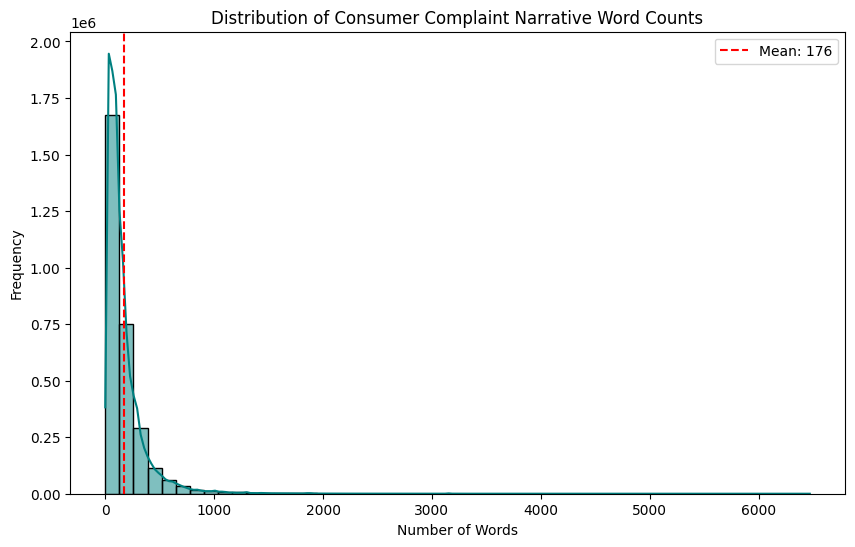

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(narrative_lengths, bins=50, kde=True, color='teal')
plt.title('Distribution of Consumer Complaint Narrative Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(narrative_lengths.mean(), color='red', linestyle='--', label=f'Mean: {narrative_lengths.mean():.0f}')
plt.legend()
plt.show()

In [8]:
# Statistical summary
print(narrative_lengths.describe())

# Identifying extreme outliers
very_short = df[df['word_count'] < 10].shape[0]
very_long = df[df['word_count'] > 1000].shape[0]

print(f"Number of extremely short narratives (<10 words): {very_short}")
print(f"Number of extremely long narratives (>1000 words): {very_long}")

count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
max      6.469000e+03
Name: Consumer complaint narrative, dtype: float64
Number of extremely short narratives (<10 words): 21938
Number of extremely long narratives (>1000 words): 32428


In [9]:
# Define the list of products we care about
target_products = [
    'Credit card or prepaid card',
    'Credit card',
    'Personal loan',
    'Student loan',
    'Payday loan, title loan, or personal loan',
    'Checking or savings account',
    'Savings account',
    'Money transfer, virtual currency, or money service'
]

# Filter the dataframe
df_filtered = df[df['Product'].isin(target_products)].copy()

print(f"Rows after product filtering: {df_filtered.shape[0]}")

Rows after product filtering: 1009657


In [10]:
# Remove records with empty narratives
df_filtered = df_filtered.dropna(subset=['Consumer complaint narrative'])

print(f"Rows after removing empty narratives: {df_filtered.shape[0]}")

Rows after removing empty narratives: 497288


In [11]:
# Check remaining products
print("Remaining Products in Dataset:")
print(df_filtered['Product'].value_counts())

# Confirm no nulls remain in the narrative column
print(f"Missing narratives: {df_filtered['Consumer complaint narrative'].isna().sum()}")

Remaining Products in Dataset:
Product
Checking or savings account                           140319
Credit card or prepaid card                           108667
Money transfer, virtual currency, or money service     97188
Credit card                                            80667
Student loan                                           53209
Payday loan, title loan, or personal loan              17238
Name: count, dtype: int64
Missing narratives: 0


In [12]:
import re

def clean_narrative(text):
    # 1. Lowercase the text
    text = str(text).lower()
    
    # 2. Remove standard boilerplate (e.g., "I am writing to file a complaint")
    # This regex looks for variations of "I am writing to..."
    text = re.sub(r'i am writing to (file a|start a|make a) complaint.*?', '', text)
    
    # 3. Remove "XX/XX/XXXX" dates (common redaction in CFPB data)
    text = re.sub(r'x{2}/x{2}/x{4}', '', text)
    
    # 4. Remove special characters (keep only alphanumeric and spaces)
    # This removes noise like "!!!" or "---"
    text = re.sub(r'[^a-z0-9\s]', '', text)
    
    # 5. Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function (this might take a few seconds on large data)
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative)

# Inspect the results
print(df_filtered[['Consumer complaint narrative', 'cleaned_narrative']].head())

                            Consumer complaint narrative  \
12237  A XXXX XXXX card was opened under my name by a...   
12532  I made the mistake of using my wellsfargo debi...   
13280  Dear CFPB, I have a secured credit card with c...   
13506  I have a Citi rewards cards. The credit balanc...   
13955  b'I am writing to dispute the following charge...   

                                       cleaned_narrative  
12237  a xxxx xxxx card was opened under my name by a...  
12532  i made the mistake of using my wellsfargo debi...  
13280  dear cfpb i have a secured credit card with ci...  
13506  i have a citi rewards cards the credit balance...  
13955  bi am writing to dispute the following charges...  


In [13]:
# Save to CSV
output_path = '../data/processed/filtered_complaints.csv'
df_filtered.to_csv(output_path, index=False)

print(f"Success! Cleaned data saved to {output_path}")

Success! Cleaned data saved to ../data/processed/filtered_complaints.csv
